In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from preprocfunctions import scale_data

## Load data

In [2]:
wine_path_red='../0. Project Data/Processed Data/1. no_duplicates/no_duplicates_red.csv'
wine_path_white='../0. Project Data/Processed Data/1. no_duplicates/no_duplicates_white.csv'
r_df=pd.read_csv(wine_path_red, sep=',')
w_df=pd.read_csv(wine_path_white, sep=',')
r_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
w_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,white


## Dummy Encoding

Our Wine Quality data is all numeric so there is no dummy encoding required (unless we want to bin some of our features but that loses us some granularity in the data) If we did have a column(s) we wanted to dummy encode we can use the following pseudo code

dummies=pd.get_dummies(df[['column 1', 'column 2']], drop_first=True)

dummies=pd.concat([df, dummies], axis=1)

dummies.drop(['column 1', 'column 2'],inplace=True)

## Scaling Data

For our wine quality data , we first have to look at the data distributions of each feature

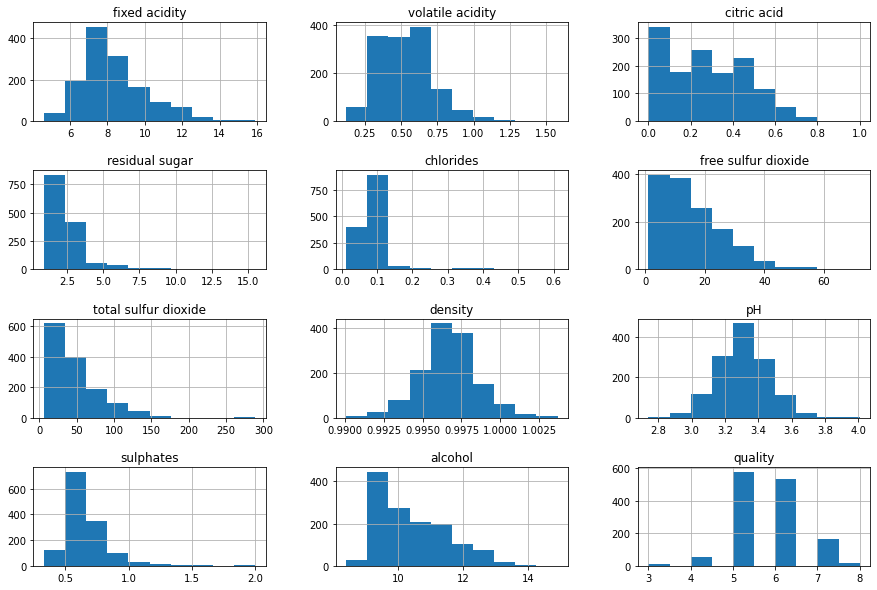

In [4]:
r_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

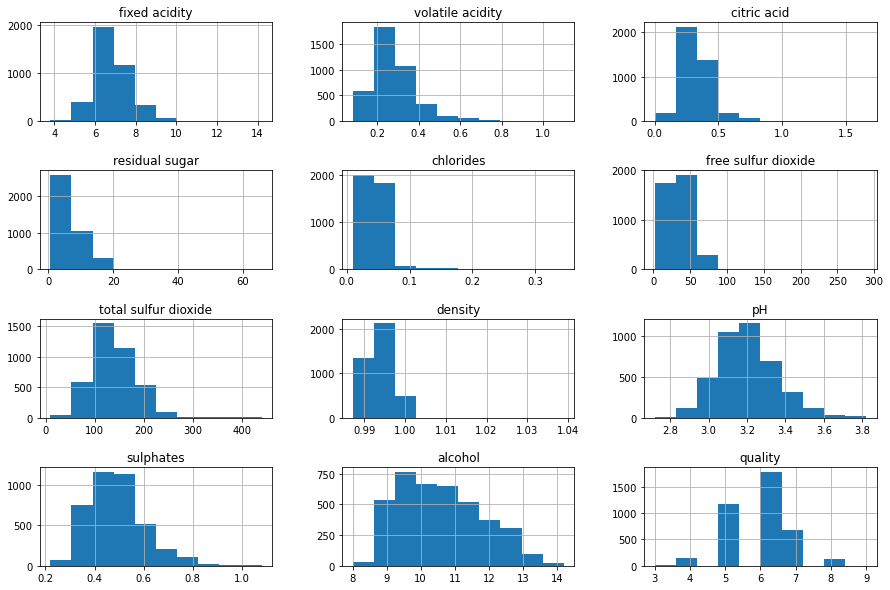

In [5]:
w_df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

None of the data distributions look gaussian except for ph and density for red wine. Because of this, we can use RobustScaler instead of StandardScaler. However since our features don't make sense with negative values which would appear with RobustScaler, we can apply a MinMaxScaler after. Scaling is most important when using algorithms that use a 'distance' based metric such as k-nearest neighbors which may have some features overpower others simply because of the scale used. Here we show how scaling affects a knn model.

### Scaling with GridSearchCV and RobustScaler and MinMaxScaler on knn model

In [6]:
y=r_df['quality']
X=r_df.drop(['quality', 'wine_type'], axis=1)

#### Unscaled KNN

In [7]:
steps=[('knn', KNeighborsClassifier())]
pipe=Pipeline(steps)
parameters= {'knn__n_neighbors': np.arange(1,50)}
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=GridSearchCV(pipe,param_grid=parameters,cv=kf,scoring='f1_macro')
cv.fit(X_train,y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='f1_macro')

In [8]:
cv.best_params_

{'knn__n_neighbors': 1}

In [9]:
cv.best_score_

0.23204925346271144

In [10]:
y_pred=cv.predict(X_test)
f1=f1_score(y_test,y_pred, average='macro')
f1

0.24197121706955482

#### Scaled KNN

Now let us add RobustScaler and MinMaxScaler

In [11]:
robust_transformer = RobustScaler()
X=robust_transformer.fit_transform(X,y)
#minmax_transformer=MinMaxScaler()
#X=minmax_transformer.fit_transform(X,y)

In [12]:
steps=[('knn', KNeighborsClassifier())]
pipe=Pipeline(steps)
parameters= {'knn__n_neighbors': np.arange(1,50)}
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=GridSearchCV(pipe,param_grid=parameters,cv=kf, scoring='f1_macro')
cv.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='f1_macro')

In [13]:
cv.best_params_

{'knn__n_neighbors': 9}

In [14]:
cv.best_score_

0.29853015902473007

In [15]:
y_pred=cv.predict(X_test)
f1=f1_score(y_test,y_pred, average='macro')
f1

0.34894959500593303

While f1_score was improved greatly, f1=0.36 is still quite low, maybe k-nearest neighbors is not the best model to use for this classification task.

## Export Scaled Data

In [16]:
red_scaled=scale_data(r_df, 'quality', ['wine_type'])
white_scaled=scale_data(w_df, 'quality', ['wine_type'])

In [17]:
red_scaled.to_csv('../0. Project Data/Processed Data/2. scaled/scaled_red.csv', index=False)
white_scaled.to_csv('../0. Project Data/Processed Data/2. scaled/scaled_white.csv', index=False)